<a id="title_ID"></a>
# A Demo of ForcePhotZTF
This is a demo of how to use the code to get forced photometry light curve for ZTF18abfcmjw (SN2019dge)! </br>

### Table of Contents 
  [Import Statements](#imports_ID) <br> 
  [Download public alert and get a sense of the lightcurve](#marshal_ID) <br> 
  [Download images from IRSA database¶](#images_ID) <br> 
  [Get observation infomation and cutouts.](#info_ID) <br>
  [Forced-PSF photometry using MCMC!](#mcmc_ID) <br>
  [Get the forced photometry from IPAC service](#IPAC_ID) <br>
  [Take a quick look at our light curve](#quicklook_ID) <br> 
  [Appendix: how about some quality cuts?](#quality_ID) 

***

<a id="imports_ID"></a>
## Import Statements

First, let's import some packages.<br> Package version should be > number listed below
- python 3.6
- numpy 1.16.2
- scipy 1.2.1
- pandas 0.24.1
- emcee 3.0rc2 [link](https://emcee.readthedocs.io/en/latest/user/install/)
- matplotlib 3.0.3
- astropy 3.1.2
- sncosmo 1.7.1
- ztfquery 1.4.0
- photutils 0.6
- coner 2.0.1
- image_registration 0.2.4
- penquins 1.0.0 [link to Kowalski](https://github.com/dmitryduev/kowalski)

Remember to add the parent path of ForcePhotZTF to your system, I use the command `sys.path.append()` for this purpose.
This demo utilized the package `multiprocessing`. You need to specify how many cores you want to use to extract the light curve (`ncpu`). Here I use the total number of cores in my laptop. 

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table

import sys
sys.path.append('/Users/yuhanyao/Documents/')

In [22]:
from ForcePhotZTF.keypairs import get_keypairs
from ForcePhotZTF.force_lc import download_marshal_lightcurve, get_coo_ZTFtarget, astrometry_spread, \
                                    get_cutout_data, download_images_diffpsf_refdiff
from ForcePhotZTF.force_mcmc import get_forced_phot_mcmc
from ForcePhotZTF.refine_lc import get_recerence_jds, plotlcs, read_ipac_lc, read_mcmc_lc

In [23]:
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

12 CPUs


__Note__: make sure that your `emcee` package is up to date, otherwise the convergence check could show error(s).<br>
I use 12 cores to run the following function, but as you can see, it still takes quite some time on my computer. <br>
If you need to deal with ~>100 targets, it's probabaly better to set this up in a server.

__ATTENTION__! You should make shure that your emcee version is [3.0rc2](https://emcee.readthedocs.io/en/latest/user/install/)! Otherwise you will run into errors.

You can check this by:

In [24]:
import emcee
emcee.__version__

'3.0rc2'

In [26]:
# name your transient: can be a ZTFname or anything you want
name = 'ZTF19aaciohh'
# provide the directory under which you want to score all of your data
targetdir = os.getcwd() + '/' + name + '/'

In [27]:
targetdir

'/Users/yuhanyao/Documents/ForcePhotZTF/ZTF19aaciohh/'

***

<a id="marshal_ID"></a>
## Download public alert lightcurve and get a sense of the lightcurve    

This step is optional. The idea is to get the public alerts light curve of this source (Patterson et al. 2019; Masci et al. 2019).

In [29]:
from penquins import Kowalski

In [30]:
DEFAULT_AUTHs = get_keypairs()
DEFAULT_AUTH_kowalski = DEFAULT_AUTHs[1] # Kowalski account username and password

In [33]:
s = Kowalski(protocol='https', host='kowalski.caltech.edu', port=443,
            verbose=False, username=DEFAULT_AUTH_kowalski[0], password=DEFAULT_AUTH_kowalski[1])

In [34]:
from utils import get_dets

In [35]:
dfs_ = get_dets(s, name)

In [36]:
dfs = []
for cand in dfs_:
    df = pd.DataFrame(cand["candidate"], index=[0])
    dfs.append(df)

dfs = pd.concat(dfs, ignore_index=True, sort=False).drop_duplicates(subset='jd').reset_index(drop=True)

In [38]:
dfs#.head()

,jd,fid,programid,ra,dec,magpsf,sigmapsf,drb
0,2.458493e+06,1,1,268.000459,65.626681,18.441322,0.095071,NaN
1,2.458493e+06,1,1,268.000468,65.626674,18.425232,0.079974,NaN
2,2.458504e+06,1,1,268.000490,65.626632,18.468069,0.095918,NaN
3,2.458507e+06,1,1,268.000516,65.626683,18.365000,0.167433,NaN
4,2.458510e+06,2,1,268.000578,65.626618,18.261812,0.118068,NaN
...,...,...,...,...,...,...,...,...
296,2.458783e+06,1,1,268.000415,65.626690,19.817934,0.168159,0.999859
297,2.458783e+06,1,1,268.000612,65.626683,19.901478,0.185784,0.999998
298,2.458788e+06,1,1,268.001324,65.626717,19.474184,0.203716,0.978311
299,2.458790e+06,1,3,268.000727,65.626754,19.682205,0.185311,0.999942


In [39]:
ixg = dfs["fid"]==1
ixr = dfs["fid"]==2
ixi = dfs["fid"]==3

In [40]:
np.sum(ixi) # no i-band public data

4

<ErrorbarContainer object of 3 artists>

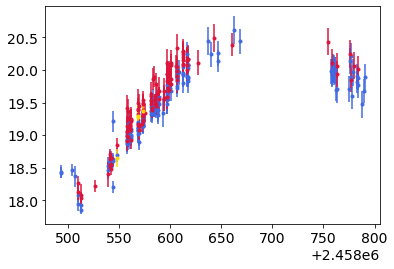

In [41]:
plt.figure()
ax = plt.subplot(111)
ax.errorbar(dfs["jd"][ixg], dfs["magpsf"][ixg], dfs["sigmapsf"][ixg], fmt = ".", color = "royalblue")
ax.errorbar(dfs["jd"][ixr], dfs["magpsf"][ixr], dfs["sigmapsf"][ixr], fmt = ".", color = "crimson")
ax.errorbar(dfs["jd"][ixi], dfs["magpsf"][ixi], dfs["sigmapsf"][ixi], fmt = ".", color = "gold")
#ax.set_ylim(20.8, 18.3)

***

<a id="images_ID"></a>
## Download images from IRSA database
Download images from ipac (psfmodel image and difference image, ~5GB each target) using a corss-match radius of 36 arcsecs (0.01 deg, which is very conservative). 

If you only want to download images between start_jd and end_jd, you can set them in the function.</br>
Settting both parameters to None will download all of images that cover this transient, which is the default option.

In [42]:
# specify the coordinate of the source
# I already know this, but you can get this info from the median of (ra, dec) from the public alerts dataset
ra = 268.0005567
dec = 65.6266366

In [48]:
# specify the range of jd to save computation time 
# I do this since I already know that there is no detections outside of the range
start_jd = 2458550
end_jd = 2458560

In [49]:
download_images_diffpsf_refdiff(targetdir, ra, dec, start_jd=start_jd, end_jd = end_jd)



Querying for metadata...
Trying to download 30 images from irsa...
In progress: 0 in 30
0 images in 30 we do not have data:


checking if all files can be opened...
In progress: 0 in 35...




***

<a id="info_ID"></a>
## Get observation infomation and cutouts.

The default cutout size is a 7x7 pixel square, where 7 = 2 x r\_psf + 1. 
Background noise is estimated by taking an annulus with inner radius = 10 pixel, and outer radius = 15 pixel. You can adjust those parameters (although I do not recommend you to do so).
        
Let's save the cutout data and observation information in two fits files.

In [52]:
targetdir

'/Users/yuhanyao/Documents/ForcePhotZTF/ZTF19aaciohh/'

In [53]:
os.mkdir(targetdir+"lightcurves")

In [54]:
r_psf = 3
r_bkg_in = 10
r_bkg_out = 15
verbose = False
get_cutout_data(name, targetdir, ra, dec, r_psf = r_psf, 
                r_bkg_in = r_bkg_in, r_bkg_out = r_bkg_out, verbose = verbose)

Start saving cutouts and observation info for ZTF19aaciohh...
In progress ZTF19aaciohh: 0 in 35...


writing data to database


Now, get the reference epochs (start jd and end jd) for each fcqf ID

In [55]:
get_recerence_jds(name, targetdir, only_partnership=False, retain_iband = True,
                  oldsuffix = '_info.fits', newsuffix = '_info_ref.fits', verbose=True)

Start getting jd of reference exposures for ZTF19aaciohh
fieldid: 825, ccdid: 13, qid: 1, filterid: 3 
 	 startjd: 2458249.82, endjd: 2458379.64 

fieldid: 825, ccdid: 13, qid: 1, filterid: 2 
 	 startjd: 2458186.91, endjd: 2458218.92 

fieldid: 826, ccdid: 16, qid: 1, filterid: 2 
 	 startjd: 2458187.02, endjd: 2458224.94 

fieldid: 825, ccdid: 13, qid: 1, filterid: 1 
 	 startjd: 2458203.89, endjd: 2458232.00 

fieldid: 826, ccdid: 16, qid: 1, filterid: 1 
 	 startjd: 2458203.87, endjd: 2458231.99 

fieldid: 848, ccdid: 2, qid: 4, filterid: 2 
 	 startjd: 2458187.02, endjd: 2458227.01 

fieldid: 848, ccdid: 2, qid: 4, filterid: 1 
 	 startjd: 2458203.90, endjd: 2458258.87 



***

<a id="mcmc_ID"></a>
## Forced-PSF photometry
- Use MCMC (the default option)

The reason why you may choose to run this (instead of IPAC's defualt lightcurve pipeline) is that this code fits the PSF with MCMC (which works better -- gives you more robust estimate of uncertainties) when the transient flux is high). The pay is the long computing time: it took 6440.7724 sec to run ~ 730 observations.

In [56]:
get_forced_phot_mcmc(name, targetdir, ncpu)

Start fitting PSF using MCMC method for ZTF19aaciohh
index = 7, Fmcmc_med = 725.03
index = 2, Fmcmc_med = 526.11
index = 10, Fmcmc_med = 560.08
index = 4, Fmcmc_med = 579.02
index = 9, Fmcmc_med = 533.57
index = 8, Fmcmc_med = 726.23
index = 3, Fmcmc_med = 586.62
index = 1, Fmcmc_med = 293.35
index = 11, Fmcmc_med = 718.45
index = 0, Fmcmc_med = 347.14
index = 6, Fmcmc_med = 748.00
index = 13, Fmcmc_med = 581.87
index = 15, Fmcmc_med = 383.58
index = 12, Fmcmc_med = 557.19
index = 19, Fmcmc_med = 591.46
index = 16, Fmcmc_med = 502.98
index = 20, Fmcmc_med = 681.04
index = 18, Fmcmc_med = 469.35
index = 17, Fmcmc_med = 613.87
index = 22, Fmcmc_med = 724.00
index = 21, Fmcmc_med = 777.21
index = 23, Fmcmc_med = 724.37
index = 24, Fmcmc_med = 647.10
index = 26, Fmcmc_med = 690.36
index = 27, Fmcmc_med = 797.06
index = 28, Fmcmc_med = 706.67
index = 30, Fmcmc_med = 339.32
index = 29, Fmcmc_med = 616.09
index = 31, Fmcmc_med = 77.18
index = 33, Fmcmc_med = 23.17
index = 34, Fmcmc_med = -18.

- Use maximum likelihood (not recommended)

If you're not interested in getting the best estimate of uncertainties, but aim for the quick-and-GoodEnough light curves. Please consider look at the file `force_maxlike.py`

***

<a id="IPAC_ID"></a>
## Get the forced photometry from IPAC service
This step is optional. We will need two columns (as quality check) to remove outliers.

In [57]:
DEFAULT_AUTH_fps = DEFAULT_AUTHs[3] # IPAC force photometry service username and password
import subprocess
info_file = targetdir+'lightcurves/force_phot_{}_info_ref.fits'.format(name)
# xy_file = targetdir+'lightcurves/xydata_{}.fits'.format(name)

info_tbl = Table.read(info_file)
# xy_tbl = Table.read(xy_file)
info_df = info_tbl.to_pandas()
# xy_df = xy_tbl.to_pandas()

In [19]:
jdstart = np.min(info_df['jdobs'])-31
jdend = np.max(info_df['jdobs'])+31
line = 'wget --http-user='+DEFAULT_AUTH_fps[0]+' --http-passwd=' + DEFAULT_AUTH_fps[1]+\
            ' -q -O log.txt '+ \
            '"https://ztfweb.ipac.caltech.edu/cgi-bin/requestForcedPhotometry.cgi?'+\
            'ra=%.7f&dec=%.7f&jdstart=%.5f&jdend=%.5f&'%(ra, dec, jdstart, jdend)+\
            'email=yyao@astro.caltech.edu"'

In [30]:
line

'wget --http-user=ztffps --http-passwd=dontgocrazy! -q -O log.txt "https://ztfweb.ipac.caltech.edu/cgi-bin/requestForcedPhotometry.cgi?ra=264.1947887&dec=50.5478260&jdstart=2458191.88073&jdend=2458794.62356&email=yyao@astro.caltech.edu"'

In [20]:
subprocess.Popen(line, shell=True)

After a few minutes you should receive an email with a link to download the lightcurve. <br>
You need to donwload the light curve and put it under `targetdir/lightcurves/`.

In [23]:
numstr = "552" # this is from the email that you received

In [24]:
line = 'wget --http-user='+DEFAULT_AUTH_fps[0]+' --http-passwd=' + DEFAULT_AUTH_fps[1]+\
        ' "https://ztfweb.ipac.caltech.edu/ztf/ops/forcedphot/lc/0/0/'+\
        'req'+numstr+'/forcedphotometry_req00000'+numstr+'_lc.txt"'

In [28]:
os.chdir(targetdir + "lightcurves/")

In [33]:
pwd

'/Users/yuhanyao/Documents/ForcePhotZTF/ZTF19aadyppr/lightcurves'

In [30]:
subprocess.Popen(line, shell=True)

Now, rename the IPAC lightcurve to `forcedphotometry_ipac_lc.txt`

In [34]:
line = "mv forcedphotometry_req00000"+numstr+"_lc.txt forcedphotometry_ipac_lc.txt"

In [35]:
subprocess.Popen(line, shell=True)

***

<a id="quicklook_ID"></a>
## Take a quick look at our light curve.

In [58]:
mylc = read_mcmc_lc(name, targetdir)

In [64]:
mylc["seeing"]

0     4.160
1     3.802
2     3.468
3     3.364
4     3.191
5     3.593
6     3.857
7     3.526
8     3.917
9     3.681
10    3.473
11    4.251
12    5.233
13    3.940
14    2.624
15    3.067
16    3.444
17    2.861
18    3.363
19    3.246
20    4.124
21    2.984
22    2.712
23    4.633
24    2.530
25    5.489
26    2.848
27    2.408
28    2.239
29    2.936
30    1.888
31    1.426
32    1.685
33    1.903
34    2.110
Name: seeing, dtype: float64

In [60]:
mylc.columns

Index(['Unnamed: 0', 'jdobs', 'filter', 'seeing', 'gain', 'zp', 'ezp',
       'programid', 'fieldid', 'ccdid', 'qid', 'filterid', 'moonra', 'moondec',
       'moonillf', 'moonphase', 'airmass', 'nbad', 'nbadbkg', 'bkgstd',
       'bkgmed', 'diffimgname', 'psfimgname', 'Fmcmc', 'Fmcmc_unc',
       'Fmcmc_low_3sigma', 'Fmcmc_low_2sigma', 'Fmcmc_low_1sigma',
       'Fmcmc_high_3sigma', 'Fmcmc_high_2sigma', 'Fmcmc_high_1sigma', 'Fratio',
       'Fratio_unc', 'jdref_start', 'jdref_end', 'fcqfid'],
      dtype='object')

In [61]:
mag = -2.5 * np.log10(mylc["Fratio"]) # AB magnitude

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
mylc["Fratio"] * 3631 # flux in Jy

0     0.000098
1     0.000044
2     0.000079
3     0.000088
4     0.000080
5     0.000084
6     0.000102
7     0.000097
8     0.000099
9     0.000085
10    0.000100
11    0.000096
12    0.000077
13    0.000094
14    0.000094
15    0.000073
16    0.000067
17    0.000081
18    0.000066
19    0.000088
20    0.000082
21    0.000101
22    0.000094
23    0.000086
24    0.000088
25    0.000074
26    0.000094
27    0.000100
28    0.000094
29    0.000084
30    0.000050
31    0.000013
32    0.000008
33    0.000003
34   -0.000002
Name: Fratio, dtype: float64

In [ ]:
ipaclc = read_ipac_lc(name, targetdir)

In [27]:
%matplotlib inline

You're encouraged to write your own function to plot the light curve. Here is a quicklook figure:

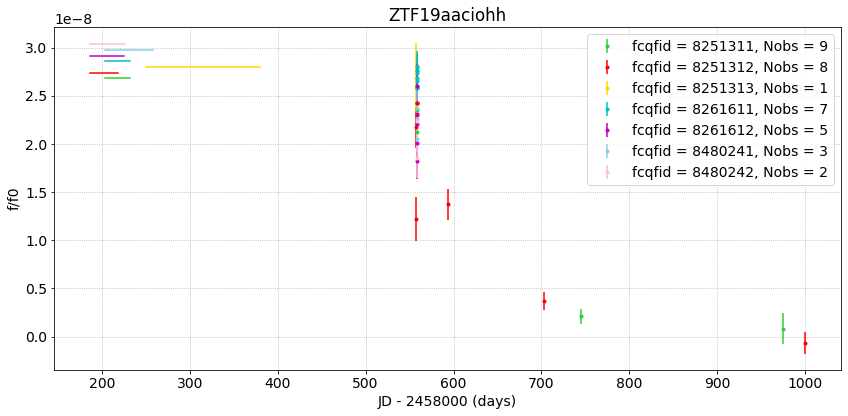

In [65]:
plotlcs(mylc, name, targetdir, seeing_cut = 7.)

***